# INTRODUCTION

## Data Definition
please refer to :
- dataDefinision.md
- data_description.txt
- CategoricalEncodingnyaPakaiApa.xlsx

## Data fields

Here's a brief version of what you'll find in the data description file.

- **SalePrice** - the property's sale price in dollars. This is the target variable that you're trying to predict.
- **MSSubClass**: The building class
- **MSZoning**: The general zoning classification
- **LotFrontage**: Linear feet of street connected to property
- **LotArea**: Lot size in square feet
- **Street**: Type of road access
- **Alley**: Type of alley access
- **LotShape**: General shape of property
- **LandContour**: Flatness of the property
- **Utilities**: Type of utilities available
- **LotConfig**: Lot configuration
- **LandSlope**: Slope of property
- **Neighborhood**: Physical locations within Ames city limits
- **Condition1**: Proximity to main road or railroad
- **Condition2**: Proximity to main road or railroad (if a second is present)
- **BldgType**: Type of dwelling
- **HouseStyle**: Style of dwelling
- **OverallQual**: Overall material and finish quality
- **OverallCond**: Overall condition rating
- **YearBuilt**: Original construction date
- **YearRemodAdd**: Remodel date
- **RoofStyle**: Type of roof
- **RoofMatl**: Roof material
- **Exterior1st**: Exterior covering on house
- **Exterior2nd**: Exterior covering on house (if more than one material)
- **MasVnrType**: Masonry veneer type
- **MasVnrArea**: Masonry veneer area in square feet
- **ExterQual**: Exterior material quality
- **ExterCond**: Present condition of the material on the exterior
- **Foundation**: Type of foundation
- **BsmtQual**: Height of the basement
- **BsmtCond**: General condition of the basement
- **BsmtExposure**: Walkout or garden level basement walls
- **BsmtFinType1**: Quality of basement finished area
- **BsmtFinSF1**: Type 1 finished square feet
- **BsmtFinType2**: Quality of second finished area (if present)
- **BsmtFinSF2**: Type 2 finished square feet
- **BsmtUnfSF**: Unfinished square feet of basement area
- **TotalBsmtSF**: Total square feet of basement area
- **Heating**: Type of heating
- **HeatingQC**: Heating quality and condition
- **CentralAir**: Central air conditioning
- **Electrical**: Electrical system
- **1stFlrSF**: First Floor square feet
- **2ndFlrSF**: Second floor square feet
- **LowQualFinSF**: Low quality finished square feet (all floors)
- **GrLivArea**: Above grade (ground) living area square feet
- **BsmtFullBath**: Basement full bathrooms
- **BsmtHalfBath**: Basement half bathrooms
- **FullBath**: Full bathrooms above grade
- **HalfBath**: Half baths above grade
- **Bedroom**: Number of bedrooms above basement level
- **Kitchen**: Number of kitchens
- **KitchenQual**: Kitchen quality
- **TotRmsAbvGrd**: Total rooms above grade (does not include bathrooms)
- **Functional**: Home functionality rating
- **Fireplaces**: Number of fireplaces
- **FireplaceQu**: Fireplace quality
- **GarageType**: Garage location
- **GarageYrBlt**: Year garage was built
- **GarageFinish**: Interior finish of the garage
- **GarageCars**: Size of garage in car capacity
- **GarageArea**: Size of garage in square feet
- **GarageQual**: Garage quality
- **GarageCond**: Garage condition
- **PavedDrive**: Paved driveway
- **WoodDeckSF**: Wood deck area in square feet
- **OpenPorchSF**: Open porch area in square feet
- **EnclosedPorch**: Enclosed porch area in square feet
- **3SsnPorch**: Three season porch area in square feet
- **ScreenPorch**: Screen porch area in square feet
- **PoolArea**: Pool area in square feet
- **PoolQC**: Pool quality
- **Fence**: Fence quality
- **MiscFeature**: Miscellaneous feature not covered in other categories
- **MiscVal**: $Value of miscellaneous feature
- **MoSold**: Month Sold
- **YrSold**: Year Sold
- **SaleType**: Type of sale
- **SaleCondition**: Condition of sale

# IMPORTS

In [669]:
# ============================ GENERAL ============================
import os
import re
import pickle
import numpy as np
import pandas as pd
from datetime import datetime

# ============================ PLOTTING ============================
import matplotlib.pyplot as plt
import seaborn as sns

# ============================ PREPROCESSING & ENCODING ============================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder

# ============================ MODELLING ============================
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ============================ EVALUATION ============================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ============================ HYPERPARAMETER TUNING ============================
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform, randint



# Function Collection

#### get_current_datetime()

In [670]:

def get_now_string(style = 1):
    # Dapetin waktu skrg
    current_datetime = datetime.now()
    
    # Cek style yang diminta
    if style == 1:
        # Format jadi format yang diminta 'yyyy-mm-dd_ddd_hhmm'
        formatted_datetime = current_datetime.strftime('%Y-%m-%d_%a_%H%M_%S')
    elif style == 2:
        # Format ke 'yyyy-mm-dd_hhmm'
        formatted_datetime = current_datetime.strftime('%Y-%m-%d_%H%M_%S')
    elif style == 3:
        # Format jadi format yang diminta 'yyyy-mm-dd_ddd_hhmm'
        formatted_datetime = current_datetime.strftime('%Y-%m-%d_%a_%H%M')
    elif style == 4:
        # Format ke 'yyyy-mm-dd_hhmm'
        formatted_datetime = current_datetime.strftime('%Y-%m-%d_%H%M')
    else:
        # Default format 'yyyy-mm-dd_ddd_hhmm'
        formatted_datetime = current_datetime.strftime('%Y-%m-%d_%a_%H%M_%S')
    
    return formatted_datetime



#### normalize_column_names()

In [671]:
def normalize_column_names(df):
    # Normalisasi setiap kolom dalam dataframe agar enak dibaca
    df.columns = [
        # Menambahkan prefix berdasarkan tipe data kolom
        ('num_' if pd.api.types.is_numeric_dtype(df[col]) else 'txt_') +
        re.sub(r'[^a-zA-Z0-9\s]', '_', col)  # Ganti simbol dengan '_'
        .replace(' ', '_')  # Ganti spasi dengan '_'
        .lower()  # Ubah ke lowercase
        for col in df.columns
    ]
    
    return df


#### printMissingInfo()

In [672]:
def printMissingInfo(df):
    missing_info =df.isnull().sum()
    missing_info = missing_info[missing_info>0]
    missing_info= missing_info.sort_values(ascending=False)
    missing_info_percentage = (missing_info / len(df)) * 100

    missing_summary = pd.DataFrame({
        'Missing Count': missing_info,
        'Missing Percentage': missing_info_percentage
    })

    return missing_summary.sort_values(by='Missing Count', ascending=False)

#### one_hot_encode_columns_general()

In [673]:
def one_hot_encode_columns_general(df, columns):
    df_encoded = pd.get_dummies(df[columns], prefix=columns)
    df = df.drop(columns=columns)
    df = pd.concat([df, df_encoded], axis=1)
    return df

#### target_encode_columns_general

In [674]:
def target_encode_columns_general(df, target_col, columns):
    te = TargetEncoder(cols=columns)
    encoded = te.fit_transform(df[columns], df[target_col])
    
    df_transformed = df.drop(columns=columns)
    df_transformed = pd.concat([df_transformed, encoded], axis=1)
    
    return df_transformed, te


#### save_model(model, filename)

In [675]:
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved to {filename}")

#### load_model(filename)

In [676]:
def load_model(filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    print(f"Model loaded from {filename}")
    return model   

#### show_corrMap(pandas_df, savedImageName)

In [677]:
def show_corrMap(pandas_df, savedImageName):
    df_corr = pandas_df.corr(numeric_only=True)
    # --- create upper-triangle mask to avoid duplicates (optional) ---
    mask = np.triu(np.ones_like(df_corr, dtype=bool))

    plt.figure(figsize=(11, 9))
    sns.heatmap(
        df_corr,
        # mask=mask,              # comment this line if you want full matrix
        cmap='coolwarm',
        center=0,
        vmin=-1, vmax=1,
        annot=True,             # <-- numbers on cells
        fmt=".2f",              # 2-decimal format
        annot_kws={"size": 8},  # font size for numbers
        linewidths=.5,
        square=True,
        cbar_kws={"shrink": .8}
    )
    plt.title('Feature Correlation Matrix (annotated)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(savedImageName, dpi=300)
    plt.show()

#### remove_highly_correlated_features(df, target_column, threshold=0.7)

In [678]:
def remove_highly_correlated_features(df, target_column, threshold=0.7):

    dfx = df.copy() 
    removed = []

    while True:
        # Calculate correlation matrix
        corr_matrix = dfx.corr()

        # make absolute value then sort highest to lowest
        high_corr_pairs = (
            corr_matrix
            .abs() 
            .where(~np.eye(len(corr_matrix), dtype=bool))  # mask diagonal
            .stack() # dataframe 2D jadi 1D (semacam di pivot jadi panjang ke bawah feature1, feature2, value)
            .sort_values(ascending=False)
        )

        # Filter corr that above threshold
        high_corr_pairs = high_corr_pairs[high_corr_pairs > threshold]
        if high_corr_pairs.empty:
            break  #selesai

        # Pick the highest correlation pair
        feature1, feature2 = high_corr_pairs.index[0]

        # Compare correlation to target
        corr_to_target = corr_matrix[target_column]
        corr1 = abs(corr_to_target.get(feature1, 0))
        corr2 = abs(corr_to_target.get(feature2, 0))
        # Remove the weaker one
        if corr1 < corr2:
            to_remove = feature1
        else:
            to_remove = feature2
        print(f'will remove {to_remove}')
        dfx.drop(columns=to_remove, inplace=True)
        
        removed.append(to_remove)

    return dfx, removed   

#### calculate_vif_v2(df, target_column, vif_threshold=5.0)

In [679]:
def calculate_vif_v2(df, target_column, vif_threshold=5.0):
   
    print('entering calculate_vif()')
    # Work on a copy of the feature set (drop the target column)
    X = df.drop(columns=[target_column]).copy()
    dropped_features = []

    while True:
        # Calculate VIF
        print('Calculate VIF')
        vif_data = pd.DataFrame()
        vif_data['feature'] = X.columns
        vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

        # Check the highest VIF
        max_vif = vif_data['VIF'].max()
        if max_vif > vif_threshold:
            feature_to_drop = vif_data.sort_values('VIF', ascending=False).iloc[0]['feature']
            print(f"📉 Dropping '{feature_to_drop}' with VIF = {max_vif:.2f}")
            X.drop(columns=[feature_to_drop], inplace=True)
            dropped_features.append(feature_to_drop)
        else:
            print("✅ All features now have VIF below threshold.")
            break

    # Final VIF report
    final_vif = pd.DataFrame()
    final_vif['feature'] = X.columns
    final_vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return pd.concat([X, df[[target_column]]], axis=1), dropped_features, final_vif

#### calculate_mape(y_actual,y_pred)

In [680]:
def calculate_mape(y_actual, y_pred):
    y_actual = np.array(y_actual)
    y_pred = np.array(y_pred)

    absolute_percentage_error = np.abs((y_actual - y_pred) / y_actual) * 100

    mape = np.mean(absolute_percentage_error)
    return mape

# EDA & Data Prep

## Load Data

In [681]:
# Load the sample data
file_path = './data/train.csv'
df = pd.read_csv(file_path)

df_original = df.copy(deep=True)


## Feature Name Normalization

In [682]:
df_01_normalize = normalize_column_names(df_original.copy(deep=True))

**num_mssubclass** ,though the content is number, but I think it is only label (based on data description)
so it should be handled as text / criteria


In [683]:
df_01_normalize=df_01_normalize.rename(columns={'num_mssubclass': 'txt_mssubclass'})

In [684]:
df=df_01_normalize.copy(deep=True)
print(df.columns)

Index(['num_id', 'txt_mssubclass', 'txt_mszoning', 'num_lotfrontage',
       'num_lotarea', 'txt_street', 'txt_alley', 'txt_lotshape',
       'txt_landcontour', 'txt_utilities', 'txt_lotconfig', 'txt_landslope',
       'txt_neighborhood', 'txt_condition1', 'txt_condition2', 'txt_bldgtype',
       'txt_housestyle', 'num_overallqual', 'num_overallcond', 'num_yearbuilt',
       'num_yearremodadd', 'txt_roofstyle', 'txt_roofmatl', 'txt_exterior1st',
       'txt_exterior2nd', 'txt_masvnrtype', 'num_masvnrarea', 'txt_exterqual',
       'txt_extercond', 'txt_foundation', 'txt_bsmtqual', 'txt_bsmtcond',
       'txt_bsmtexposure', 'txt_bsmtfintype1', 'num_bsmtfinsf1',
       'txt_bsmtfintype2', 'num_bsmtfinsf2', 'num_bsmtunfsf',
       'num_totalbsmtsf', 'txt_heating', 'txt_heatingqc', 'txt_centralair',
       'txt_electrical', 'num_1stflrsf', 'num_2ndflrsf', 'num_lowqualfinsf',
       'num_grlivarea', 'num_bsmtfullbath', 'num_bsmthalfbath', 'num_fullbath',
       'num_halfbath', 'num_bedroomab

## mini EDA summary

In [685]:
# Membuat ringkasan EDA
eda_summary = {
    "Dataset Shape": df.shape,
    "Column Names": df.columns.tolist(),
    
    # Menampilkan hanya kolom dengan missing values dan jumlah missing values-nya
    "Missing Values": df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False).apply(lambda x: f"{x}"),
    
    "Numerical Features": df.select_dtypes(include=['number']).columns.tolist(),
    "Categorical Features": df.select_dtypes(include=['object']).columns.tolist(),
    "Sample Data": df.head(15)
}

# Menyiapkan direktori dan nama file output
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)  # Membuat folder jika belum ada
output_file = os.path.join(output_dir, f'{get_now_string()}_summary.txt')

# Menulis ringkasan EDA ke dalam file teks
with open(output_file, 'w') as f:
    f.write("Exploratory Data Analysis Summary:\n\n")
    
    # Menyusun data ringkasan dan menulis ke file
    for key, value in eda_summary.items():
        f.write(f"{key}:\n")
        
        # Mengubah list atau DataFrame menjadi string
        if isinstance(value, (list, pd.Series)):
            value = '\n'.join(map(str, value))  # Menyusun elemen list menjadi string
        elif isinstance(value, pd.DataFrame):
            value = value.to_string(index=False)  # Mengubah DataFrame menjadi string tanpa index

        f.write(f"{value}\n\n")

# Menampilkan pesan bahwa ringkasan telah ditulis
print(f"Summary ditulis ke {output_file}")


Summary ditulis ke output\2025-06-11_Wed_1602_26_summary.txt


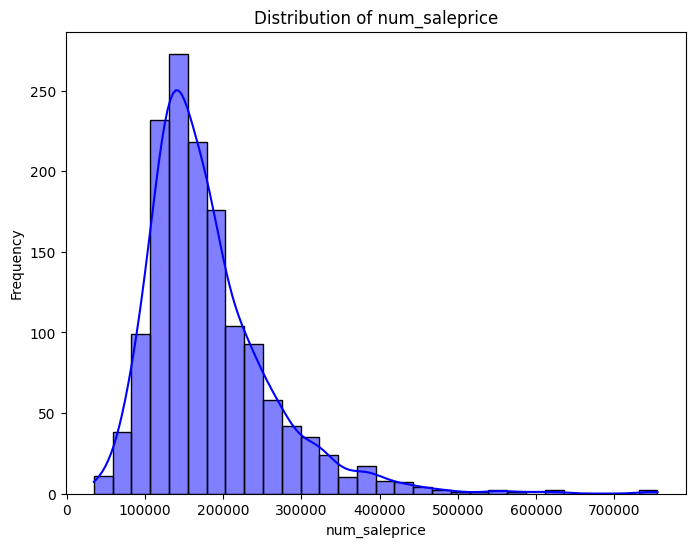

Skewness of num_saleprice: 1.8828757597682129


In [686]:
feature = 'num_saleprice'

# Plot distribution
plt.figure(figsize=(8, 6))
sns.histplot(df[feature], kde=True, color='blue', bins=30)
plt.title(f'Distribution of {feature}')
plt.xlabel(feature)
plt.ylabel('Frequency')
plt.show()

# Calculate skewness
skewness = df[feature].skew()

# Display skewness
print(f'Skewness of {feature}: {skewness}')

## Handling Missing Values

In [687]:
printMissingInfo(df)

,Missing Count,Missing Percentage
txt_poolqc,1453,99.520548
txt_miscfeature,1406,96.301370
txt_alley,1369,93.767123
txt_fence,1179,80.753425
txt_fireplacequ,690,47.260274
num_lotfrontage,259,17.739726
txt_garagefinish,81,5.547945
txt_garagecond,81,5.547945
txt_garagequal,81,5.547945
num_garageyrblt,81,5.547945


### txt_poolqc

In [688]:
# =============================
# Cek kolom txt_poolqc
# =============================

print(df['txt_poolqc'].unique())

ygNull = df['txt_poolqc'].isnull()
df_filtered = df[ygNull]
df_result = df_filtered[['num_poolarea', 'txt_poolqc']]
print(df_result)

ygKosong = df_result['num_poolarea'] == 0
df_result2 = df_result[ygKosong]
print(df_result2)

[nan 'Ex' 'Fa' 'Gd']
      num_poolarea txt_poolqc
0                0        NaN
1                0        NaN
2                0        NaN
3                0        NaN
4                0        NaN
...            ...        ...
1455             0        NaN
1456             0        NaN
1457             0        NaN
1458             0        NaN
1459             0        NaN

[1453 rows x 2 columns]
      num_poolarea txt_poolqc
0                0        NaN
1                0        NaN
2                0        NaN
3                0        NaN
4                0        NaN
...            ...        ...
1455             0        NaN
1456             0        NaN
1457             0        NaN
1458             0        NaN
1459             0        NaN

[1453 rows x 2 columns]


In [689]:
# =============================
# Cek kolom txt_poolqc
# =============================
df.loc[df['num_poolarea'] == 0, 'txt_poolqc'] = "NA"

print(df['txt_poolqc'].unique())


['NA' 'Ex' 'Fa' 'Gd']


In [690]:
printMissingInfo(df)

,Missing Count,Missing Percentage
txt_miscfeature,1406,96.301370
txt_alley,1369,93.767123
txt_fence,1179,80.753425
txt_fireplacequ,690,47.260274
num_lotfrontage,259,17.739726
txt_garagefinish,81,5.547945
txt_garagequal,81,5.547945
txt_garagecond,81,5.547945
num_garageyrblt,81,5.547945
txt_garagetype,81,5.547945


### txt_miscfeature

In [691]:
# =============================
# Cek kolom txt_miscfeature     
# =============================
df.loc[df['txt_miscfeature'].isnull() , 'txt_miscfeature'] = "NA"

print(df['txt_miscfeature'].unique())


['NA' 'Shed' 'Gar2' 'Othr' 'TenC']


In [692]:
printMissingInfo(df)

,Missing Count,Missing Percentage
txt_alley,1369,93.767123
txt_fence,1179,80.753425
txt_fireplacequ,690,47.260274
num_lotfrontage,259,17.739726
txt_garagefinish,81,5.547945
txt_garagequal,81,5.547945
txt_garagecond,81,5.547945
num_garageyrblt,81,5.547945
txt_garagetype,81,5.547945
txt_bsmtexposure,38,2.602740


### txt_alley

In [693]:
# =============================
# Cek kolom txt_alley     
# =============================
print(df['txt_alley'].unique())

df.loc[df['txt_alley'].isnull() , 'txt_alley'] = "NA"



[nan 'Grvl' 'Pave']


In [694]:
printMissingInfo(df)

,Missing Count,Missing Percentage
txt_fence,1179,80.753425
txt_fireplacequ,690,47.260274
num_lotfrontage,259,17.739726
txt_garagetype,81,5.547945
num_garageyrblt,81,5.547945
txt_garagefinish,81,5.547945
txt_garagequal,81,5.547945
txt_garagecond,81,5.547945
txt_bsmtexposure,38,2.602740
txt_bsmtfintype2,38,2.602740


### Cek kolom txt_fence     

In [695]:
# =============================
# Cek kolom txt_fence     
# =============================
print(df['txt_fence'].unique())

df.loc[df['txt_fence'].isnull() , 'txt_fence'] = "NA"



[nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']


In [696]:
printMissingInfo(df)

,Missing Count,Missing Percentage
txt_fireplacequ,690,47.260274
num_lotfrontage,259,17.739726
txt_garagetype,81,5.547945
num_garageyrblt,81,5.547945
txt_garagefinish,81,5.547945
txt_garagequal,81,5.547945
txt_garagecond,81,5.547945
txt_bsmtexposure,38,2.602740
txt_bsmtfintype2,38,2.602740
txt_bsmtqual,37,2.534247


### txt_fireplacequ

In [697]:
# =============================
# Cek kolom txt_fireplacequ
# =============================

print(df['txt_fireplacequ'].unique())

ygNull = df['txt_fireplacequ'].isnull()
df_filtered = df[ygNull]
df_result = df_filtered[['num_fireplaces', 'txt_fireplacequ']]
print(df_result)

ygKosong = df_result['num_fireplaces'] == 0
df_result2 = df_result[ygKosong]
print(df_result2)

[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
      num_fireplaces txt_fireplacequ
0                  0             NaN
5                  0             NaN
10                 0             NaN
12                 0             NaN
15                 0             NaN
...              ...             ...
1452               0             NaN
1453               0             NaN
1454               0             NaN
1458               0             NaN
1459               0             NaN

[690 rows x 2 columns]
      num_fireplaces txt_fireplacequ
0                  0             NaN
5                  0             NaN
10                 0             NaN
12                 0             NaN
15                 0             NaN
...              ...             ...
1452               0             NaN
1453               0             NaN
1454               0             NaN
1458               0             NaN
1459               0             NaN

[690 rows x 2 columns]


In [698]:
# =============================
# Cek kolom txt_fireplacequ
# =============================
print(df['txt_fireplacequ'].unique())

df.loc[df['num_fireplaces'] == 0, 'txt_fireplacequ'] = "NA"



[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']


In [699]:
printMissingInfo(df)

,Missing Count,Missing Percentage
num_lotfrontage,259,17.739726
txt_garagetype,81,5.547945
num_garageyrblt,81,5.547945
txt_garagefinish,81,5.547945
txt_garagequal,81,5.547945
txt_garagecond,81,5.547945
txt_bsmtexposure,38,2.602740
txt_bsmtfintype2,38,2.602740
txt_bsmtqual,37,2.534247
txt_bsmtcond,37,2.534247


### txt_garagetype , txt_garagefinish,  txt_garagequal,txt_garagecond,num_garageyrblt

In [700]:
# =============================
# Cek kolom txt_garagetype
# =============================

print(df['txt_garagetype'].unique())

ygNull = df['txt_garagetype'].isnull()
df_filtered = df[ygNull]
df_result = df_filtered[['num_garageyrblt', 'txt_garagetype','txt_garagefinish','txt_garagequal','txt_garagecond']]
print(df_result)

ygKosong = df_result['num_garageyrblt'] == 0
df_result2 = df_result[ygKosong]
print(df_result2)

['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
      num_garageyrblt txt_garagetype txt_garagefinish txt_garagequal  \
39                NaN            NaN              NaN            NaN   
48                NaN            NaN              NaN            NaN   
78                NaN            NaN              NaN            NaN   
88                NaN            NaN              NaN            NaN   
89                NaN            NaN              NaN            NaN   
...               ...            ...              ...            ...   
1349              NaN            NaN              NaN            NaN   
1407              NaN            NaN              NaN            NaN   
1449              NaN            NaN              NaN            NaN   
1450              NaN            NaN              NaN            NaN   
1453              NaN            NaN              NaN            NaN   

     txt_garagecond  
39              NaN  
48              NaN  
78    

In [701]:
# =============================
# Cek kolom txt_garagetype
# =============================
print(df['txt_garagetype'].unique())

df.loc[df['num_garageyrblt'].isnull(), 'txt_garagetype'] = "NA"
df.loc[df['num_garageyrblt'].isnull(), 'txt_garagefinish'] = "NA"
df.loc[df['num_garageyrblt'].isnull(), 'txt_garagequal'] = "NA"
df.loc[df['num_garageyrblt'].isnull(), 'txt_garagecond'] = "NA"
df.loc[df['num_garageyrblt'].isnull(), 'num_garageyrblt'] = 0


['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']


In [702]:
print(df['num_garageyrblt'].unique())

[2003. 1976. 2001. 1998. 2000. 1993. 2004. 1973. 1931. 1939. 1965. 2005.
 1962. 2006. 1960. 1991. 1970. 1967. 1958. 1930. 2002. 1968. 2007. 2008.
 1957. 1920. 1966. 1959. 1995. 1954. 1953.    0. 1983. 1977. 1997. 1985.
 1963. 1981. 1964. 1999. 1935. 1990. 1945. 1987. 1989. 1915. 1956. 1948.
 1974. 2009. 1950. 1961. 1921. 1900. 1979. 1951. 1969. 1936. 1975. 1971.
 1923. 1984. 1926. 1955. 1986. 1988. 1916. 1932. 1972. 1918. 1980. 1924.
 1996. 1940. 1949. 1994. 1910. 1978. 1982. 1992. 1925. 1941. 2010. 1927.
 1947. 1937. 1942. 1938. 1952. 1928. 1922. 1934. 1906. 1914. 1946. 1908.
 1929. 1933.]


In [703]:
printMissingInfo(df)

,Missing Count,Missing Percentage
num_lotfrontage,259,17.739726
txt_bsmtexposure,38,2.602740
txt_bsmtfintype2,38,2.602740
txt_bsmtqual,37,2.534247
txt_bsmtcond,37,2.534247
txt_bsmtfintype1,37,2.534247
txt_masvnrtype,8,0.547945
num_masvnrarea,8,0.547945
txt_electrical,1,0.068493


### txt_bsmtexposure,txt_bsmtfintype2,txt_bsmtqual,txt_bsmtcond,txt_bsmtfintype1

In [704]:
# =============================
# Cek kolom txt_bsmtexposure
# =============================

# print(df['num_totalbsmtsf'].unique())
# print(df['txt_bsmtexposure'].unique())
# print(df['txt_bsmtfintype2'].unique())
# print(df['txt_bsmtqual'].unique())
# print(df['txt_bsmtcond'].unique())
# print(df['txt_bsmtfintype1'].unique())

ygNull = df['txt_bsmtexposure'].isnull()
df_filtered = df[ygNull]
df_result = df_filtered[['num_totalbsmtsf', 'txt_bsmtexposure','txt_bsmtfintype2','txt_bsmtqual','txt_bsmtcond','txt_bsmtfintype1']]
print(df_result)

ygKosong = df_result['num_totalbsmtsf'] == 0
df_result2 = df_result[ygKosong]
print(df_result2)

      num_totalbsmtsf txt_bsmtexposure txt_bsmtfintype2 txt_bsmtqual  \
17                  0              NaN              NaN          NaN   
39                  0              NaN              NaN          NaN   
90                  0              NaN              NaN          NaN   
102                 0              NaN              NaN          NaN   
156                 0              NaN              NaN          NaN   
182                 0              NaN              NaN          NaN   
259                 0              NaN              NaN          NaN   
342                 0              NaN              NaN          NaN   
362                 0              NaN              NaN          NaN   
371                 0              NaN              NaN          NaN   
392                 0              NaN              NaN          NaN   
520                 0              NaN              NaN          NaN   
532                 0              NaN              NaN         

In [705]:
# =============================
# Cek kolom txt_bsmtexposure
# =============================
print(df['txt_bsmtexposure'].unique())
df.loc[df['num_totalbsmtsf']==0, 'txt_bsmtexposure'] = "NA"
print(df['txt_bsmtexposure'].unique())

['No' 'Gd' 'Mn' 'Av' nan]
['No' 'Gd' 'Mn' 'Av' 'NA' nan]


In [706]:
# =============================
# Cek kolom txt_bsmtfintype2
# =============================
print(df['txt_bsmtfintype2'].unique())
df.loc[df['num_totalbsmtsf']==0, 'txt_bsmtfintype2'] = "NA"
print(df['txt_bsmtfintype2'].unique())

['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
['Unf' 'BLQ' 'NA' 'ALQ' 'Rec' 'LwQ' 'GLQ' nan]


In [707]:
# =============================
# Cek kolom txt_bsmtqual
# =============================
print(df['txt_bsmtqual'].unique())
df.loc[df['num_totalbsmtsf']==0, 'txt_bsmtqual'] = "NA"
print(df['txt_bsmtqual'].unique())

['Gd' 'TA' 'Ex' nan 'Fa']
['Gd' 'TA' 'Ex' 'NA' 'Fa']


In [708]:
# =============================
# Cek kolom txt_bsmtcond
# =============================
print(df['txt_bsmtcond'].unique())
df.loc[df['num_totalbsmtsf']==0, 'txt_bsmtcond'] = "NA"
print(df['txt_bsmtcond'].unique())

['TA' 'Gd' nan 'Fa' 'Po']
['TA' 'Gd' 'NA' 'Fa' 'Po']


In [709]:
# =============================
# Cek kolom txt_bsmtfintype1
# =============================
print(df['txt_bsmtfintype1'].unique())
df.loc[df['num_totalbsmtsf']==0, 'txt_bsmtfintype1'] = "NA"
print(df['txt_bsmtfintype1'].unique())

['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'NA' 'LwQ']


In [710]:
printMissingInfo(df)


,Missing Count,Missing Percentage
num_lotfrontage,259,17.739726
txt_masvnrtype,8,0.547945
num_masvnrarea,8,0.547945
txt_bsmtexposure,1,0.068493
txt_bsmtfintype2,1,0.068493
txt_electrical,1,0.068493


In [711]:
# =============================
# Cek kolom txt_bsmtexposure
# =============================

print(df['txt_bsmtexposure'].unique())
print(df['txt_bsmtfintype2'].unique())

print('---------------------------------------')

ygNull = df['txt_bsmtexposure'].isnull()
df_filtered = df[ygNull]
df_result = df_filtered[['num_totalbsmtsf', 'txt_bsmtexposure','txt_bsmtfintype2']]
print(df_result)

print('---------------------------------------')

ygNull = df['txt_bsmtfintype2'].isnull()
df_filtered = df[ygNull]
df_result = df_filtered[['num_totalbsmtsf', 'txt_bsmtexposure','txt_bsmtfintype2']]
print(df_result)

print('---------------------------------------')

ygKosong = df_result['num_totalbsmtsf'] == 0
df_result2 = df_result[ygKosong]
print(df_result2)

['No' 'Gd' 'Mn' 'Av' 'NA' nan]
['Unf' 'BLQ' 'NA' 'ALQ' 'Rec' 'LwQ' 'GLQ' nan]
---------------------------------------
     num_totalbsmtsf txt_bsmtexposure txt_bsmtfintype2
948              936              NaN              Unf
---------------------------------------
     num_totalbsmtsf txt_bsmtexposure txt_bsmtfintype2
332             3206               No              NaN
---------------------------------------
Empty DataFrame
Columns: [num_totalbsmtsf, txt_bsmtexposure, txt_bsmtfintype2]
Index: []


In [712]:
# =============================
# Cek kolom txt_bsmtexposure
# =============================
print(df['txt_bsmtexposure'].unique())
df.loc[df['txt_bsmtexposure'].isnull(), 'txt_bsmtexposure'] = "NA"
print(df['txt_bsmtexposure'].unique())

['No' 'Gd' 'Mn' 'Av' 'NA' nan]
['No' 'Gd' 'Mn' 'Av' 'NA']


In [713]:
# =============================
# Cek kolom txt_bsmtfintype2
# =============================
print(df['txt_bsmtfintype2'].unique())
df.loc[df['txt_bsmtfintype2'].isnull(), 'txt_bsmtfintype2'] = "NA"
print(df['txt_bsmtfintype2'].unique())

['Unf' 'BLQ' 'NA' 'ALQ' 'Rec' 'LwQ' 'GLQ' nan]
['Unf' 'BLQ' 'NA' 'ALQ' 'Rec' 'LwQ' 'GLQ']


In [714]:
printMissingInfo(df)

,Missing Count,Missing Percentage
num_lotfrontage,259,17.739726
txt_masvnrtype,8,0.547945
num_masvnrarea,8,0.547945
txt_electrical,1,0.068493


### txt_masvnrtype

In [715]:
# =============================
# Cek kolom txt_masvnrtype
# =============================

print(df['txt_masvnrtype'].unique())

ygNull = df['txt_masvnrtype'].isnull()
df_filtered = df[ygNull]
df_result = df_filtered[['num_masvnrarea', 'txt_masvnrtype']]
print(df_result)

ygKosong = df_result['num_masvnrarea'] == 0
df_result2 = df_result[ygKosong]
print(df_result2)

['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
      num_masvnrarea txt_masvnrtype
234              NaN            NaN
529              NaN            NaN
650              NaN            NaN
936              NaN            NaN
973              NaN            NaN
977              NaN            NaN
1243             NaN            NaN
1278             NaN            NaN
Empty DataFrame
Columns: [num_masvnrarea, txt_masvnrtype]
Index: []


In [716]:
# =============================
# Cek kolom txt_masvnrtype
# =============================
print(df['txt_masvnrtype'].unique())
df.loc[df['num_masvnrarea'].isnull(), 'txt_masvnrtype'] = "None"
print(df['txt_masvnrtype'].unique())

['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
['BrkFace' 'None' 'Stone' 'BrkCmn']


In [717]:
# =============================
# Cek kolom txt_masvnrtype
# =============================
# print(df['num_masvnrarea'].unique())
df.loc[df['num_masvnrarea'].isnull(), 'num_masvnrarea'] = 0
# print(df['num_masvnrarea'].unique())

In [718]:
printMissingInfo(df)

,Missing Count,Missing Percentage
num_lotfrontage,259,17.739726
txt_electrical,1,0.068493


### txt_electrical

In [719]:
# =============================
# Cek kolom txt_electrical
# =============================

print(df['txt_electrical'].unique())

ygNull = df['txt_electrical'].isnull()
df_filtered = df[ygNull]
df_result =  df_filtered[['txt_electrical','txt_heating','txt_utilities']]
print(df_result)

electrical_counts_groupby = df[df['txt_utilities'] == 'AllPub'].groupby('txt_electrical').size()
print(electrical_counts_groupby)


['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]
     txt_electrical txt_heating txt_utilities
1379            NaN        GasA        AllPub
txt_electrical
FuseA      93
FuseF      27
FuseP       3
Mix         1
SBrkr    1334
dtype: int64


In [720]:
# =============================
# Cek kolom txt_electrical
# =============================
print(df['txt_electrical'].unique())
df.loc[df['txt_electrical'].isnull(), 'txt_electrical'] = 'FuseA'
print(df['txt_electrical'].unique())

['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]
['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix']


In [721]:
printMissingInfo(df)

,Missing Count,Missing Percentage
num_lotfrontage,259,17.739726


### num_lotfrontage

In [722]:
df.corr()['num_saleprice']['num_lotfrontage']

C:\Users\andyp\AppData\Local\Temp\ipykernel_14532\3975267678.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['num_saleprice']['num_lotfrontage']


0.35179909657067737

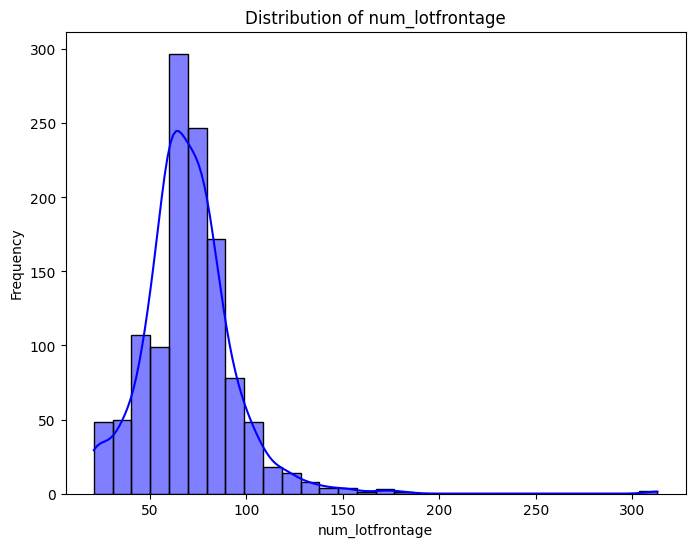

Skewness of num_lotfrontage: 2.163569142324884


In [723]:
feature = 'num_lotfrontage'

# Plot distribution
plt.figure(figsize=(8, 6))
sns.histplot(df[feature], kde=True, color='blue', bins=30)
plt.title(f'Distribution of {feature}')
plt.xlabel(feature)
plt.ylabel('Frequency')
plt.show()

# Calculate skewness
skewness = df[feature].skew()

# Display skewness
print(f'Skewness of {feature}: {skewness}')

In [724]:
num_lotfrontage_median_by_txt_neighborhood = df.groupby('txt_neighborhood')['num_lotfrontage'].median().reset_index()
print(num_lotfrontage_median_by_txt_neighborhood)


   txt_neighborhood  num_lotfrontage
0           Blmngtn             43.0
1           Blueste             24.0
2            BrDale             21.0
3           BrkSide             52.0
4           ClearCr             80.0
5           CollgCr             70.0
6           Crawfor             74.0
7           Edwards             65.5
8           Gilbert             65.0
9            IDOTRR             60.0
10          MeadowV             21.0
11          Mitchel             73.0
12            NAmes             73.0
13          NPkVill             24.0
14           NWAmes             80.0
15          NoRidge             91.0
16          NridgHt             88.5
17          OldTown             60.0
18            SWISU             60.0
19           Sawyer             71.0
20          SawyerW             66.5
21          Somerst             73.5
22          StoneBr             61.5
23           Timber             85.0
24          Veenker             68.0


In [725]:
num_lotfrontage_median_by_txt_neighborhood.rename(columns={'num_lotfrontage': 'num_medianlotfrontage_by_neighborhood'}, inplace=True)
print(num_lotfrontage_median_by_txt_neighborhood)


   txt_neighborhood  num_medianlotfrontage_by_neighborhood
0           Blmngtn                                   43.0
1           Blueste                                   24.0
2            BrDale                                   21.0
3           BrkSide                                   52.0
4           ClearCr                                   80.0
5           CollgCr                                   70.0
6           Crawfor                                   74.0
7           Edwards                                   65.5
8           Gilbert                                   65.0
9            IDOTRR                                   60.0
10          MeadowV                                   21.0
11          Mitchel                                   73.0
12            NAmes                                   73.0
13          NPkVill                                   24.0
14           NWAmes                                   80.0
15          NoRidge                                   91

In [726]:
df_merged = pd.merge(
    df,
    num_lotfrontage_median_by_txt_neighborhood,
    on='txt_neighborhood',  # Join key
    how='left'          # Keep all rows from df
)
print(df_merged[df_merged['num_lotfrontage'].isnull()][['txt_neighborhood', 'num_lotfrontage', 'num_medianlotfrontage_by_neighborhood']])


     txt_neighborhood  num_lotfrontage  num_medianlotfrontage_by_neighborhood
7              NWAmes              NaN                                   80.0
12             Sawyer              NaN                                   71.0
14              NAmes              NaN                                   73.0
16              NAmes              NaN                                   73.0
24             Sawyer              NaN                                   71.0
...               ...              ...                                    ...
1429           NWAmes              NaN                                   80.0
1431          NPkVill              NaN                                   24.0
1441          CollgCr              NaN                                   70.0
1443          BrkSide              NaN                                   52.0
1446          Mitchel              NaN                                   73.0

[259 rows x 3 columns]


In [727]:
df_merged['num_lotfrontage2'] = np.where(df_merged['num_lotfrontage'].notnull(), 
                                          df_merged['num_lotfrontage'], 
                                          df_merged['num_medianlotfrontage_by_neighborhood'])
df_merged.drop(columns=['num_lotfrontage', 'num_medianlotfrontage_by_neighborhood'], inplace=True)
df_merged.rename(columns={'num_lotfrontage2': 'num_lotfrontage'}, inplace=True)
df=df_merged.copy(deep=True)


In [728]:
printMissingInfo(df)

,Missing Count,Missing Percentage


In [729]:
txt_columns = [col for col in df.columns if col.startswith('txt_')]
unique_values = {}
for col in txt_columns:
    # Get the unique values for the current column and add it to the dictionary
    unique_values[col] = df[col].nunique()

print(unique_values)

listnya=list(unique_values.items())
unique_values_df=pd.DataFrame(listnya, columns=['Column', 'UniqueValueCount'])

print(unique_values_df)
unique_values_df.to_csv(f'./output/{get_now_string()}_unique_values_df.csv', index=False)


{'txt_mssubclass': 15, 'txt_mszoning': 5, 'txt_street': 2, 'txt_alley': 3, 'txt_lotshape': 4, 'txt_landcontour': 4, 'txt_utilities': 2, 'txt_lotconfig': 5, 'txt_landslope': 3, 'txt_neighborhood': 25, 'txt_condition1': 9, 'txt_condition2': 8, 'txt_bldgtype': 5, 'txt_housestyle': 8, 'txt_roofstyle': 6, 'txt_roofmatl': 8, 'txt_exterior1st': 15, 'txt_exterior2nd': 16, 'txt_masvnrtype': 4, 'txt_exterqual': 4, 'txt_extercond': 5, 'txt_foundation': 6, 'txt_bsmtqual': 5, 'txt_bsmtcond': 5, 'txt_bsmtexposure': 5, 'txt_bsmtfintype1': 7, 'txt_bsmtfintype2': 7, 'txt_heating': 6, 'txt_heatingqc': 5, 'txt_centralair': 2, 'txt_electrical': 5, 'txt_kitchenqual': 4, 'txt_functional': 7, 'txt_fireplacequ': 6, 'txt_garagetype': 7, 'txt_garagefinish': 4, 'txt_garagequal': 6, 'txt_garagecond': 6, 'txt_paveddrive': 3, 'txt_poolqc': 4, 'txt_fence': 5, 'txt_miscfeature': 5, 'txt_saletype': 9, 'txt_salecondition': 6}
               Column  UniqueValueCount
0      txt_mssubclass                15
1        txt_m

based on checking (see : CategoricalEncodingnyaPakaiApa.xlsx)
<br>
######################
<br>
**no need encoding** <br>
'txt_overallqual', 'txt_overallcond',

**OHE** <br>
'txt_street','txt_alley','txt_landslope','txt_centralair','txt_paveddrive',

**Target Encoding** <br>
'txt_mssubclass','txt_mszoning','txt_lotshape','txt_landcontour','txt_utilities',<br>
'txt_lotconfig','txt_neighborhood','txt_condition1','txt_condition2','txt_bldgtype',<br>
'txt_housestyle','txt_roofstyle','txt_roofmatl','txt_exterior1st','txt_exterior2nd',<br>
'txt_masvnrtype','txt_exterqual','txt_extercond','txt_foundation','txt_bsmtqual',<br>
'txt_bsmtcond','txt_bsmtexposure','txt_bsmtfintype1','txt_bsmtfintype2','txt_heating',<br>
'txt_heatingqc','txt_electrical','txt_kitchenqual','txt_functional','txt_fireplacequ',<br>
'txt_garagetype','txt_garagefinish','txt_garagequal','txt_garagecond','txt_poolqc',<br>
'txt_fence','txt_miscfeature','txt_saletype','txt_salecondition',

untuk :
- 'txt_mssubclass',
- 'txt_mszoning',
- 'txt_utilities',
- 'txt_condition2',
- 'txt_exterior1st',
- 'txt_exterior2nd',
- 'txt_masvnrtype',
- 'txt_exterqual',
- 'txt_bsmtqual',
- 'txt_bsmtcond',
- 'txt_kitchenqual',
- 'txt_functional',
- 'txt_poolqc',
- 'txt_miscfeature',
- 'txt_saletype',
<br>

jumlah unique value pada data is less than what is listed in data description / definition .<br>
but for the simplicity of this project (and we don't have new data that might have <br>
categorical values other than that already listed in the curren data ), <br>
i decided not to include any categorical value that is listed in the data description / definition but<br>
not listed in the training/test data



## One Hot Encoding

In [730]:
df = one_hot_encode_columns_general(df, ['txt_street','txt_alley','txt_landslope','txt_centralair','txt_paveddrive'])
df.columns

Index(['num_id', 'txt_mssubclass', 'txt_mszoning', 'num_lotarea',
       'txt_lotshape', 'txt_landcontour', 'txt_utilities', 'txt_lotconfig',
       'txt_neighborhood', 'txt_condition1', 'txt_condition2', 'txt_bldgtype',
       'txt_housestyle', 'num_overallqual', 'num_overallcond', 'num_yearbuilt',
       'num_yearremodadd', 'txt_roofstyle', 'txt_roofmatl', 'txt_exterior1st',
       'txt_exterior2nd', 'txt_masvnrtype', 'num_masvnrarea', 'txt_exterqual',
       'txt_extercond', 'txt_foundation', 'txt_bsmtqual', 'txt_bsmtcond',
       'txt_bsmtexposure', 'txt_bsmtfintype1', 'num_bsmtfinsf1',
       'txt_bsmtfintype2', 'num_bsmtfinsf2', 'num_bsmtunfsf',
       'num_totalbsmtsf', 'txt_heating', 'txt_heatingqc', 'txt_electrical',
       'num_1stflrsf', 'num_2ndflrsf', 'num_lowqualfinsf', 'num_grlivarea',
       'num_bsmtfullbath', 'num_bsmthalfbath', 'num_fullbath', 'num_halfbath',
       'num_bedroomabvgr', 'num_kitchenabvgr', 'txt_kitchenqual',
       'num_totrmsabvgrd', 'txt_functional'

## Data Splitting

In [731]:
from sklearn.model_selection import train_test_split

X = df.drop("num_saleprice", axis=1)
y = df["num_saleprice"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

#create backup as usual 
df_train.to_csv(f'./output/{get_now_string()}_df_train.csv', index=False)
df_test.to_csv(f'./output/{get_now_string()}_df_test.csv', index=False)


In [732]:
print(f'df_train.shape={df_train.shape}')
print(f'df_test.shape={df_test.shape}')

df_train.shape=(1168, 89)
df_test.shape=(292, 89)


## Target Encoding after Splitting

In [733]:
df_train, encodernya = target_encode_columns_general(df_train, target_col='num_saleprice'
                                               , columns=['txt_mssubclass','txt_mszoning','txt_lotshape','txt_landcontour','txt_utilities','txt_lotconfig',
                                                          'txt_neighborhood','txt_condition1','txt_condition2','txt_bldgtype','txt_housestyle',
                                                          'txt_roofstyle','txt_roofmatl','txt_exterior1st','txt_exterior2nd','txt_masvnrtype',
                                                          'txt_exterqual','txt_extercond','txt_foundation','txt_bsmtqual','txt_bsmtcond',
                                                          'txt_bsmtexposure','txt_bsmtfintype1','txt_bsmtfintype2','txt_heating','txt_heatingqc',
                                                          'txt_electrical','txt_kitchenqual','txt_functional','txt_fireplacequ','txt_garagetype',
                                                          'txt_garagefinish','txt_garagequal','txt_garagecond','txt_poolqc','txt_fence',
                                                          'txt_miscfeature','txt_saletype','txt_salecondition'])


In [734]:
df_test_full = df_test.copy()

#endcoder only process the feature that need to be target encoded so does the encoding result
#so we need to copy the full df , DROP the features being encoded, and ADD the encoded result back

df_transformed_cols = encodernya.transform(df_test[['txt_mssubclass','txt_mszoning','txt_lotshape','txt_landcontour','txt_utilities','txt_lotconfig',
                                                          'txt_neighborhood','txt_condition1','txt_condition2','txt_bldgtype','txt_housestyle',
                                                          'txt_roofstyle','txt_roofmatl','txt_exterior1st','txt_exterior2nd','txt_masvnrtype',
                                                          'txt_exterqual','txt_extercond','txt_foundation','txt_bsmtqual','txt_bsmtcond',
                                                          'txt_bsmtexposure','txt_bsmtfintype1','txt_bsmtfintype2','txt_heating','txt_heatingqc',
                                                          'txt_electrical','txt_kitchenqual','txt_functional','txt_fireplacequ','txt_garagetype',
                                                          'txt_garagefinish','txt_garagequal','txt_garagecond','txt_poolqc','txt_fence',
                                                          'txt_miscfeature','txt_saletype','txt_salecondition']])


df_test_full = df_test_full.drop(columns=['txt_mssubclass','txt_mszoning','txt_lotshape','txt_landcontour','txt_utilities','txt_lotconfig',
                                                          'txt_neighborhood','txt_condition1','txt_condition2','txt_bldgtype','txt_housestyle',
                                                          'txt_roofstyle','txt_roofmatl','txt_exterior1st','txt_exterior2nd','txt_masvnrtype',
                                                          'txt_exterqual','txt_extercond','txt_foundation','txt_bsmtqual','txt_bsmtcond',
                                                          'txt_bsmtexposure','txt_bsmtfintype1','txt_bsmtfintype2','txt_heating','txt_heatingqc',
                                                          'txt_electrical','txt_kitchenqual','txt_functional','txt_fireplacequ','txt_garagetype',
                                                          'txt_garagefinish','txt_garagequal','txt_garagecond','txt_poolqc','txt_fence',
                                                          'txt_miscfeature','txt_saletype','txt_salecondition'])

df_test = pd.concat([df_test_full, df_transformed_cols], axis=1)


In [735]:
print(f'df_train.shape={df_train.shape}')
print(f'df_test.shape={df_test.shape}')

df_train.shape=(1168, 89)
df_test.shape=(292, 89)


## Steps summary for data prepreprocessing:
- normalize column names
- handle missing values
- doing OHE before splitting
- doing Target Encoding after splitting


# MODELING

## Baseline Model

In [736]:
results_df = pd.DataFrame([{
    "Model": '-',
    "RMSE": 0,
    "MAE": 0,
    "MAPE": 0,    
    "R2": 0,
    "Model File": '',
    "df_train": '',
    "df_test":'',
    "Scaler File":''
}])


In [737]:
X_train = df_train.drop(columns=['num_saleprice'])
y_train = df_train['num_saleprice']
X_test = df_test.drop(columns=['num_saleprice'])
y_test = df_test['num_saleprice']

### Baseline Linear Regression

In [738]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test,y_pred)

sekarang = f'./output/{get_now_string()}'
model_name = 'baseline_model_linear_regression'
model_file_name = f'{sekarang}_{model_name}.pkl'
df_train_filename= f'{sekarang}_{model_name}_df_train.csv'
df_test_filename= f'{sekarang}_{model_name}_df_test.csv'

save_model(model, model_file_name)
df_train.to_csv(df_train_filename)
df_test.to_csv(df_test_filename)


resultnya = pd.DataFrame([{
    "Model": model_name,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Model File": model_file_name,
    "df_train": df_train_filename,
    "df_test": df_test_filename,
    "Scaler File":''
}])

results_df = pd.concat([results_df, resultnya], ignore_index=True)

print(results_df[['Model','RMSE','MAE','MAPE','R2']])

Model saved to ./output/2025-06-11_Wed_1602_34_baseline_model_linear_regression.pkl
                              Model          RMSE           MAE      MAPE  \
0                                 -      0.000000      0.000000   0.00000   
1  baseline_model_linear_regression  32170.161993  20080.659064  11.82033   

         R2  
0  0.000000  
1  0.865075  


### Random Forest

In [739]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test,y_pred)

sekarang = f'./output/{get_now_string()}'
model_name = 'baseline_model_random_Forest'
model_file_name = f'{sekarang}_{model_name}.pkl'
df_train_filename= f'{sekarang}_{model_name}_df_train.csv'
df_test_filename= f'{sekarang}_{model_name}_df_test.csv'

save_model(model, model_file_name)
df_train.to_csv(df_train_filename)
df_test.to_csv(df_test_filename)


resultnya = pd.DataFrame([{
    "Model": model_name,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Model File": model_file_name,
    "df_train": df_train_filename,
    "df_test": df_test_filename,
    "Scaler File":''
}])

results_df = pd.concat([results_df, resultnya], ignore_index=True)

print(results_df[['Model','RMSE','MAE','MAPE','R2']])

Model saved to ./output/2025-06-11_Wed_1602_43_baseline_model_random_Forest.pkl
                              Model          RMSE           MAE       MAPE  \
0                                 -      0.000000      0.000000   0.000000   
1  baseline_model_linear_regression  32170.161993  20080.659064  11.820330   
2      baseline_model_random_Forest  28636.283593  17416.832671  10.520635   

         R2  
0  0.000000  
1  0.865075  
2  0.893090  


### XGBoost

In [740]:
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test,y_pred)

sekarang = f'./output/{get_now_string()}'
model_name = 'baseline_model_XGB'
model_file_name = f'{sekarang}_{model_name}.pkl'
df_train_filename= f'{sekarang}_{model_name}_df_train.csv'
df_test_filename= f'{sekarang}_{model_name}_df_test.csv'

save_model(model, model_file_name)
df_train.to_csv(df_train_filename)
df_test.to_csv(df_test_filename)


resultnya = pd.DataFrame([{
    "Model": model_name,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Model File": model_file_name,
    "df_train": df_train_filename,
    "df_test": df_test_filename,
    "Scaler File":''
}])

results_df = pd.concat([results_df, resultnya], ignore_index=True)

print(results_df[['Model','RMSE','MAE','MAPE','R2']])

Model saved to ./output/2025-06-11_Wed_1602_44_baseline_model_XGB.pkl
                              Model          RMSE           MAE       MAPE  \
0                                 -      0.000000      0.000000   0.000000   
1  baseline_model_linear_regression  32170.161993  20080.659064  11.820330   
2      baseline_model_random_Forest  28636.283593  17416.832671  10.520635   
3                baseline_model_XGB  29502.500001  16806.905982  10.269786   

         R2  
0  0.000000  
1  0.865075  
2  0.893090  
3  0.886524  


In [741]:
results_df

,Model,RMSE,MAE,MAPE,R2,Model File,df_train,df_test,Scaler File
0,-,0.000000,0.000000,0.000000,0.000000,,,,
1,baseline_model_linear_regression,32170.161993,20080.659064,11.820330,0.865075,./output/2025-06-11_Wed_1602_34_baseline_model...,./output/2025-06-11_Wed_1602_34_baseline_model...,./output/2025-06-11_Wed_1602_34_baseline_model...,
2,baseline_model_random_Forest,28636.283593,17416.832671,10.520635,0.893090,./output/2025-06-11_Wed_1602_43_baseline_model...,./output/2025-06-11_Wed_1602_43_baseline_model...,./output/2025-06-11_Wed_1602_43_baseline_model...,
3,baseline_model_XGB,29502.500001,16806.905982,10.269786,0.886524,./output/2025-06-11_Wed_1602_44_baseline_model...,./output/2025-06-11_Wed_1602_44_baseline_model...,./output/2025-06-11_Wed_1602_44_baseline_model...,


## Feature Engineering


In [742]:
df_train_ori = df_train.copy(deep=True)
df_test_ori = df_test.copy(deep=True)

print(f'df_train = {df_train.shape}')
print(f'df_test = {df_test.shape}')

df_train = (1168, 89)
df_test = (292, 89)


In [743]:
df_train=df_train_ori.copy(deep=True)
df_test=df_test_ori.copy(deep=True)

In [744]:
df_train.columns

Index(['num_id', 'num_lotarea', 'num_overallqual', 'num_overallcond',
       'num_yearbuilt', 'num_yearremodadd', 'num_masvnrarea', 'num_bsmtfinsf1',
       'num_bsmtfinsf2', 'num_bsmtunfsf', 'num_totalbsmtsf', 'num_1stflrsf',
       'num_2ndflrsf', 'num_lowqualfinsf', 'num_grlivarea', 'num_bsmtfullbath',
       'num_bsmthalfbath', 'num_fullbath', 'num_halfbath', 'num_bedroomabvgr',
       'num_kitchenabvgr', 'num_totrmsabvgrd', 'num_fireplaces',
       'num_garageyrblt', 'num_garagecars', 'num_garagearea', 'num_wooddecksf',
       'num_openporchsf', 'num_enclosedporch', 'num_3ssnporch',
       'num_screenporch', 'num_poolarea', 'num_miscval', 'num_mosold',
       'num_yrsold', 'num_lotfrontage', 'txt_street_Grvl', 'txt_street_Pave',
       'txt_alley_Grvl', 'txt_alley_NA', 'txt_alley_Pave', 'txt_landslope_Gtl',
       'txt_landslope_Mod', 'txt_landslope_Sev', 'txt_centralair_N',
       'txt_centralair_Y', 'txt_paveddrive_N', 'txt_paveddrive_P',
       'txt_paveddrive_Y', 'num_salepric

karena nanti we will using Linear regression too (plan : Linear Regression, Random Forest, XGBoost)
we need to do scaling on the data <br>
but scaling is only for the Linear Regression Steps



### combined features

In [745]:
def add_combined_features(dfnya):

    #custom feature ini dibuat as simple as grouping some feature that have similarity on their characteristics on supporting the house price
    #you can find the process of the grouping in supportind document "CategoricalEncodingnyaPakaiApa.xlsx"
    
    dfnya['new_qualities'] = 	dfnya['num_overallqual'] + dfnya['txt_exterqual'] + dfnya['txt_bsmtqual'] + dfnya['txt_heatingqc'] + dfnya['num_lowqualfinsf'] + dfnya['num_halfbath'] + dfnya['num_kitchenabvgr'] + dfnya['txt_kitchenqual'] + dfnya['txt_fireplacequ'] + dfnya['txt_garagequal'] + dfnya['txt_poolqc'] + dfnya['txt_fence']
    dfnya['new_condition'] = 	dfnya['txt_condition1'] + dfnya['txt_condition2'] + dfnya['num_overallcond'] + dfnya['txt_extercond'] + dfnya['txt_bsmtcond'] + dfnya['txt_heatingqc'] + dfnya['txt_centralair_Y'] + dfnya['num_2ndflrsf'] + dfnya['txt_garagecond'] + dfnya['txt_salecondition']
    dfnya['new_square'] = 	dfnya['num_lotarea'] + dfnya['num_masvnrarea'] + dfnya['num_bsmtfinsf1'] + dfnya['num_bsmtfinsf2'] + dfnya['num_bsmtunfsf'] + dfnya['num_totalbsmtsf'] + dfnya['num_1stflrsf'] + dfnya['num_2ndflrsf'] + dfnya['num_lowqualfinsf'] + dfnya['num_grlivarea'] + dfnya['num_garagecars'] + dfnya['num_garagearea'] + dfnya['num_wooddecksf'] + dfnya['num_openporchsf'] + dfnya['num_enclosedporch'] + dfnya['num_3ssnporch'] + dfnya['num_screenporch'] + dfnya['num_poolarea']
    dfnya['new_counts'] = 	dfnya['num_totalbsmtsf'] + dfnya['num_bsmtfullbath'] + dfnya['num_bsmthalfbath'] + dfnya['num_fullbath'] + dfnya['num_bedroomabvgr'] + dfnya['num_totrmsabvgrd'] + dfnya['num_fireplaces'] + dfnya['num_garagecars']
    dfnya['new_types'] = 	dfnya['txt_mssubclass'] + (dfnya['txt_street_Grvl']*1)+ (dfnya['txt_street_Pave']*2)+(dfnya['txt_alley_NA'] *0) + (dfnya['txt_alley_Grvl'] *1) + (dfnya['txt_alley_Pave'] *2) + dfnya['txt_utilities'] + dfnya['txt_bldgtype'] + dfnya['txt_housestyle'] + dfnya['txt_roofstyle'] + dfnya['txt_masvnrtype'] + dfnya['txt_foundation'] + dfnya['txt_bsmtfintype1'] + dfnya['txt_bsmtfintype2'] + dfnya['txt_heating'] + dfnya['txt_functional'] + dfnya['txt_saletype']
    dfnya['new_interiorexterior'] = 	dfnya['num_overallqual'] + dfnya['txt_roofstyle'] + dfnya['txt_roofmatl'] + dfnya['txt_exterior1st'] + dfnya['txt_exterior2nd'] + dfnya['txt_masvnrtype'] + dfnya['txt_bsmtfintype1'] + dfnya['num_bsmtfinsf1'] + dfnya['txt_bsmtfintype2'] + dfnya['num_bsmtfinsf2'] + dfnya['num_bsmtunfsf'] + dfnya['num_lowqualfinsf'] + dfnya['txt_garagefinish']
    dfnya['new_neighbour'] = 	dfnya['txt_mssubclass'] + dfnya['txt_mszoning'] + dfnya['num_lotfrontage'] + (dfnya['txt_street_Grvl']*1)+ (dfnya['txt_street_Pave']*2) + (dfnya['txt_alley_NA'] *0) + (dfnya['txt_alley_Grvl'] *1) + (dfnya['txt_alley_Pave'] *2)  + dfnya['txt_landcontour'] + (dfnya['txt_landslope_Gtl'] *1) + (dfnya['txt_landslope_Mod'] *2) + (dfnya['txt_landslope_Sev'] *3)  + dfnya['txt_neighborhood'] + dfnya['txt_bsmtexposure'] + dfnya['txt_garagetype'] + (dfnya['txt_paveddrive_N'] *1) + (dfnya['txt_paveddrive_P'] *2) + (dfnya['txt_paveddrive_Y'] *3)  + dfnya['txt_fence']
    dfnya['new_facilities'] = 	dfnya['txt_utilities'] + dfnya['txt_heating'] + dfnya['txt_electrical'] + dfnya['num_fireplaces'] + dfnya['txt_miscfeature'] + dfnya['num_miscval']
    dfnya['new_shapes'] = 	dfnya['txt_lotshape'] + dfnya['txt_lotconfig'] + dfnya['txt_housestyle'] + dfnya['txt_bsmtexposure']
    dfnya['new_time'] = 	((dfnya['num_yrsold']- ((dfnya['num_yearbuilt'] + dfnya['num_yearremodadd'])/2))+(dfnya['num_yrsold']- dfnya['num_garageyrblt']))/2
    return dfnya

In [746]:
df_train = add_combined_features(df_train)
df_test = add_combined_features(df_test)

In [747]:
df_train_corr = df_train.corr(numeric_only=True)
# show_corrMap(df_train_corr,f'./output/{sekarang}_df_train_corr.jpg')

### drop feature yang correlation lemah <= 0.05

In [748]:
selection_threshold = 0.05 # correlation threshold
selected_features_prep=df_train_corr['num_saleprice']
print(f'sebelum dipilih=\n{selected_features_prep}')

sebelum dipilih=
num_id                 -0.019643
num_lotarea             0.266204
num_overallqual         0.785555
num_overallcond        -0.074391
num_yearbuilt           0.516501
                          ...   
new_interiorexterior    0.648828
new_neighbour           0.729466
new_facilities          0.248124
new_shapes              0.494898
new_time               -0.297257
Name: num_saleprice, Length: 99, dtype: float64


In [749]:
selected_features = selected_features_prep[abs(selected_features_prep) > selection_threshold]
print('')
print(f'selected_featres=\n{selected_features}')


selected_featres=
num_lotarea             0.266204
num_overallqual         0.785555
num_overallcond        -0.074391
num_yearbuilt           0.516501
num_yearremodadd        0.508593
                          ...   
new_interiorexterior    0.648828
new_neighbour           0.729466
new_facilities          0.248124
new_shapes              0.494898
new_time               -0.297257
Name: num_saleprice, Length: 87, dtype: float64


In [750]:
selected_feature_names = selected_features.index.to_list()
print(selected_feature_names)
df_train=df_train[selected_feature_names]

['num_lotarea', 'num_overallqual', 'num_overallcond', 'num_yearbuilt', 'num_yearremodadd', 'num_masvnrarea', 'num_bsmtfinsf1', 'num_bsmtunfsf', 'num_totalbsmtsf', 'num_1stflrsf', 'num_2ndflrsf', 'num_grlivarea', 'num_bsmtfullbath', 'num_fullbath', 'num_halfbath', 'num_bedroomabvgr', 'num_kitchenabvgr', 'num_totrmsabvgrd', 'num_fireplaces', 'num_garageyrblt', 'num_garagecars', 'num_garagearea', 'num_wooddecksf', 'num_openporchsf', 'num_enclosedporch', 'num_3ssnporch', 'num_screenporch', 'num_poolarea', 'num_lotfrontage', 'txt_alley_Grvl', 'txt_alley_NA', 'txt_landslope_Gtl', 'txt_landslope_Sev', 'txt_centralair_N', 'txt_centralair_Y', 'txt_paveddrive_N', 'txt_paveddrive_P', 'txt_paveddrive_Y', 'num_saleprice', 'txt_mssubclass', 'txt_mszoning', 'txt_lotshape', 'txt_landcontour', 'txt_lotconfig', 'txt_neighborhood', 'txt_condition1', 'txt_condition2', 'txt_bldgtype', 'txt_housestyle', 'txt_roofstyle', 'txt_roofmatl', 'txt_exterior1st', 'txt_exterior2nd', 'txt_masvnrtype', 'txt_exterqual',

### remove features with high correlation betwen features (>0.8)

In [751]:
print(df_train.shape)
target_column = 'num_saleprice' 
df_train, removed_features = remove_highly_correlated_features(df_train, target_column, threshold=0.8)

(1168, 87)
will remove txt_centralair_Y
will remove num_totalbsmtsf
will remove num_garageyrblt
will remove num_lotarea
will remove txt_electrical
will remove txt_saletype
will remove txt_exterior2nd
will remove txt_garagecond
will remove txt_garagequal
will remove num_garagearea
will remove txt_exterqual
will remove txt_paveddrive_N
will remove num_fireplaces
will remove new_interiorexterior
will remove txt_kitchenqual
will remove num_1stflrsf
will remove num_totrmsabvgrd
will remove txt_bsmtqual
will remove txt_neighborhood
will remove num_overallqual


### remove features with high VIF Score > 5

-- I disabled automatic VIF since it making model worse, it removing some important features

In [752]:
# df_train, removed_features, VIF_result = calculate_vif_v2(df_train,'num_saleprice', 7.5)
# print(removed_features)
# print(VIF_result)

In [753]:
# print(removed_features)

In [754]:
# print(VIF_result)

In [755]:
df_train.shape

(1168, 67)

In [756]:
df_train.columns

Index(['num_overallcond', 'num_yearbuilt', 'num_yearremodadd',
       'num_masvnrarea', 'num_bsmtfinsf1', 'num_bsmtunfsf', 'num_2ndflrsf',
       'num_grlivarea', 'num_bsmtfullbath', 'num_fullbath', 'num_halfbath',
       'num_bedroomabvgr', 'num_kitchenabvgr', 'num_garagecars',
       'num_wooddecksf', 'num_openporchsf', 'num_enclosedporch',
       'num_3ssnporch', 'num_screenporch', 'num_poolarea', 'num_lotfrontage',
       'txt_alley_Grvl', 'txt_alley_NA', 'txt_landslope_Gtl',
       'txt_landslope_Sev', 'txt_centralair_N', 'txt_paveddrive_P',
       'txt_paveddrive_Y', 'num_saleprice', 'txt_mssubclass', 'txt_mszoning',
       'txt_lotshape', 'txt_landcontour', 'txt_lotconfig', 'txt_condition1',
       'txt_condition2', 'txt_bldgtype', 'txt_housestyle', 'txt_roofstyle',
       'txt_roofmatl', 'txt_exterior1st', 'txt_masvnrtype', 'txt_extercond',
       'txt_foundation', 'txt_bsmtcond', 'txt_bsmtexposure',
       'txt_bsmtfintype1', 'txt_bsmtfintype2', 'txt_heating', 'txt_heatingqc',

In [757]:
df_train.columns
df_test=df_test[df_train.columns]

print(f'df_train = {df_train.shape}')
print(f'df_test = {df_test.shape}')

X_train = df_train.drop(columns=['num_saleprice'])
y_train = df_train['num_saleprice']
X_test = df_test.drop(columns=['num_saleprice'])
y_test = df_test['num_saleprice']

df_train = (1168, 67)
df_test = (292, 67)


## Modelling without Tuning

### LinearRegression

#### scaling

In [758]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)  # Add column names
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)  # Add column names

df_train_scaled = pd.concat([X_train_scaled_df, y_train.reset_index(drop=True)], axis=1)
df_test_scaled = pd.concat([X_test_scaled_df, y_test.reset_index(drop=True)], axis=1)

sekarang = f'./output/{get_now_string()}'
scaler_name = 'scaler'

scaler_file_name = f'{sekarang}_{scaler_name}.pkl'
df_train_filename= f'{sekarang}_df_train_scaled.csv'
df_test_filename= f'{sekarang}_df_test_scaled.csv'

save_model(scaler, scaler_file_name)
df_train_scaled.to_csv(df_train_filename)
df_test_scaled.to_csv(df_test_filename)


X_train_scaled = df_train_scaled.drop(columns=['num_saleprice'])
y_train_scaled = df_train_scaled['num_saleprice']
X_test_scaled = df_test_scaled.drop(columns=['num_saleprice'])
y_test_scaled = df_test_scaled['num_saleprice']

Model saved to ./output/2025-06-11_Wed_1602_46_scaler.pkl


In [759]:
#### Linear Regression modeling

In [760]:
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)
y_pred = model.predict(X_test_scaled)


rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred))
mae = mean_absolute_error(y_test_scaled, y_pred)
r2 = r2_score(y_test_scaled, y_pred)
mape = calculate_mape(y_test_scaled,y_pred)

sekarang = f'./output/{get_now_string()}'
model_name = 'feauterEng_model_linear_regression'
model_file_name = f'{sekarang}_{model_name}.pkl'
df_train_filename= f'{sekarang}_{model_name}_df_train.csv'
df_test_filename= f'{sekarang}_{model_name}_df_test.csv'

save_model(model, model_file_name)
df_train.to_csv(df_train_filename)
df_test.to_csv(df_test_filename)


resultnya = pd.DataFrame([{
    "Model": model_name,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Model File": model_file_name,
    "df_train": df_train_filename,
    "df_test": df_test_filename,
    "Scaler File":''
}])

results_df = pd.concat([results_df, resultnya], ignore_index=True)

print(results_df[['Model','RMSE','MAE','MAPE','R2']])

Model saved to ./output/2025-06-11_Wed_1602_46_feauterEng_model_linear_regression.pkl
                                Model          RMSE           MAE       MAPE  \
0                                   -      0.000000      0.000000   0.000000   
1    baseline_model_linear_regression  32170.161993  20080.659064  11.820330   
2        baseline_model_random_Forest  28636.283593  17416.832671  10.520635   
3                  baseline_model_XGB  29502.500001  16806.905982  10.269786   
4  feauterEng_model_linear_regression  32811.140792  21068.336528  12.847550   

         R2  
0  0.000000  
1  0.865075  
2  0.893090  
3  0.886524  
4  0.859645  


### RandomForestRegressor

In [761]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test,y_pred)

sekarang = f'./output/{get_now_string()}'
model_name = 'feauterEng_model_random_Forest'
model_file_name = f'{sekarang}_{model_name}.pkl'
df_train_filename= f'{sekarang}_{model_name}_df_train.csv'
df_test_filename= f'{sekarang}_{model_name}_df_test.csv'

save_model(model, model_file_name)
df_train.to_csv(df_train_filename)
df_test.to_csv(df_test_filename)


resultnya = pd.DataFrame([{
    "Model": model_name,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Model File": model_file_name,
    "df_train": df_train_filename,
    "df_test": df_test_filename,
    "Scaler File":''
}])

results_df = pd.concat([results_df, resultnya], ignore_index=True)

print(results_df[['Model','RMSE','MAE','MAPE','R2']])

Model saved to ./output/2025-06-11_Wed_1602_53_feauterEng_model_random_Forest.pkl
                                Model          RMSE           MAE       MAPE  \
0                                   -      0.000000      0.000000   0.000000   
1    baseline_model_linear_regression  32170.161993  20080.659064  11.820330   
2        baseline_model_random_Forest  28636.283593  17416.832671  10.520635   
3                  baseline_model_XGB  29502.500001  16806.905982  10.269786   
4  feauterEng_model_linear_regression  32811.140792  21068.336528  12.847550   
5      feauterEng_model_random_Forest  28428.911961  17292.903733  10.992030   

         R2  
0  0.000000  
1  0.865075  
2  0.893090  
3  0.886524  
4  0.859645  
5  0.894633  


### XGBRegressor

In [762]:
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test,y_pred)

sekarang = f'./output/{get_now_string()}'
model_name = 'feauterEng_model_XGB'
model_file_name = f'{sekarang}_{model_name}.pkl'
df_train_filename= f'{sekarang}_{model_name}_df_train.csv'
df_test_filename= f'{sekarang}_{model_name}_df_test.csv'

save_model(model, model_file_name)
df_train.to_csv(df_train_filename)
df_test.to_csv(df_test_filename)


resultnya = pd.DataFrame([{
    "Model": model_name,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Model File": model_file_name,
    "df_train": df_train_filename,
    "df_test": df_test_filename,
    "Scaler File":''
}])

results_df = pd.concat([results_df, resultnya], ignore_index=True)

print(results_df[['Model','RMSE','MAE','MAPE','R2']])

Model saved to ./output/2025-06-11_Wed_1602_54_feauterEng_model_XGB.pkl
                                Model          RMSE           MAE       MAPE  \
0                                   -      0.000000      0.000000   0.000000   
1    baseline_model_linear_regression  32170.161993  20080.659064  11.820330   
2        baseline_model_random_Forest  28636.283593  17416.832671  10.520635   
3                  baseline_model_XGB  29502.500001  16806.905982  10.269786   
4  feauterEng_model_linear_regression  32811.140792  21068.336528  12.847550   
5      feauterEng_model_random_Forest  28428.911961  17292.903733  10.992030   
6                feauterEng_model_XGB  35132.400028  19010.372324  11.127679   

         R2  
0  0.000000  
1  0.865075  
2  0.893090  
3  0.886524  
4  0.859645  
5  0.894633  
6  0.839083  


In [763]:
results_df

,Model,RMSE,MAE,MAPE,R2,Model File,df_train,df_test,Scaler File
0,-,0.000000,0.000000,0.000000,0.000000,,,,
1,baseline_model_linear_regression,32170.161993,20080.659064,11.820330,0.865075,./output/2025-06-11_Wed_1602_34_baseline_model...,./output/2025-06-11_Wed_1602_34_baseline_model...,./output/2025-06-11_Wed_1602_34_baseline_model...,
2,baseline_model_random_Forest,28636.283593,17416.832671,10.520635,0.893090,./output/2025-06-11_Wed_1602_43_baseline_model...,./output/2025-06-11_Wed_1602_43_baseline_model...,./output/2025-06-11_Wed_1602_43_baseline_model...,
3,baseline_model_XGB,29502.500001,16806.905982,10.269786,0.886524,./output/2025-06-11_Wed_1602_44_baseline_model...,./output/2025-06-11_Wed_1602_44_baseline_model...,./output/2025-06-11_Wed_1602_44_baseline_model...,
4,feauterEng_model_linear_regression,32811.140792,21068.336528,12.847550,0.859645,./output/2025-06-11_Wed_1602_46_feauterEng_mod...,./output/2025-06-11_Wed_1602_46_feauterEng_mod...,./output/2025-06-11_Wed_1602_46_feauterEng_mod...,
5,feauterEng_model_random_Forest,28428.911961,17292.903733,10.992030,0.894633,./output/2025-06-11_Wed_1602_53_feauterEng_mod...,./output/2025-06-11_Wed_1602_53_feauterEng_mod...,./output/2025-06-11_Wed_1602_53_feauterEng_mod...,
6,feauterEng_model_XGB,35132.400028,19010.372324,11.127679,0.839083,./output/2025-06-11_Wed_1602_54_feauterEng_mod...,./output/2025-06-11_Wed_1602_54_feauterEng_mod...,./output/2025-06-11_Wed_1602_54_feauterEng_mod...,


## Tuning

### Tuning RandomSearch Random Forrest

In [764]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np
import pandas as pd

# --- Custom RMSE scorer ---
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# --- Random Forest hyperparameter space ---
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 2),
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# --- Initialize model ---
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# --- RandomizedSearchCV ---
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,
    scoring=rmse_scorer,
    cv=5,
    verbose=1,
    random_state=42
)

# --- Fit the model ---
random_search.fit(X_train, y_train)

# --- Best model, parameters, and CV score ---
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = -random_search.best_score_  # Convert from negative RMSE

# --- Predict ---
y_pred = best_model.predict(X_test)

# --- Metrics ---
rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)

# --- Save outputs ---
sekarang = f'./output/{get_now_string()}'
model_name = 'tuned_RndSrch_model_RF'
model_file_name = f'{sekarang}_{model_name}.pkl'
df_train_filename = f'{sekarang}_{model_name}_df_train.csv'
df_test_filename = f'{sekarang}_{model_name}_df_test.csv'

save_model(best_model, model_file_name)
df_train.to_csv(df_train_filename, index=False)
df_test.to_csv(df_test_filename, index=False)

# --- Log results ---
resultnya = pd.DataFrame([{
    "Model": model_name,
    "RMSE": rmse_score,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Model File": model_file_name,
    "df_train": df_train_filename,
    "df_test": df_test_filename,
    "Scaler File": ''
}])

results_df = pd.concat([results_df, resultnya], ignore_index=True)

# Show result summary
print(results_df[['Model', 'RMSE', 'MAE', 'MAPE', 'R2']])


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Model saved to ./output/2025-06-11_Wed_1633_47_tuned_RndSrch_model_RF.pkl
                                Model          RMSE           MAE       MAPE  \
0                                   -      0.000000      0.000000   0.000000   
1    baseline_model_linear_regression  32170.161993  20080.659064  11.820330   
2        baseline_model_random_Forest  28636.283593  17416.832671  10.520635   
3                  baseline_model_XGB  29502.500001  16806.905982  10.269786   
4  feauterEng_model_linear_regression  32811.140792  21068.336528  12.847550   
5      feauterEng_model_random_Forest  28428.911961  17292.903733  10.992030   
6                feauterEng_model_XGB  35132.400028  19010.372324  11.127679   
7              tuned_RndSrch_model_RF  29297.120138  17325.634801  11.033650   

         R2  
0  0.000000  
1  0.865075  
2  0.893090  
3  0.886524  
4  0.859645  
5  0.894633  
6  0.839083  
7  0.888098  


In [765]:
best_model

RandomForestRegressor(bootstrap=False, max_depth=11, max_features='sqrt',
                      min_samples_split=4, n_estimators=212, n_jobs=-1,
                      random_state=42)

In [766]:
best_params

{'bootstrap': False,
 'max_depth': 11,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 212}

In [ ]:
best_params_rf = best_params

In [767]:
best_score

28814.25132531041

In [768]:
results_df

,Model,RMSE,MAE,MAPE,R2,Model File,df_train,df_test,Scaler File
0,-,0.000000,0.000000,0.000000,0.000000,,,,
1,baseline_model_linear_regression,32170.161993,20080.659064,11.820330,0.865075,./output/2025-06-11_Wed_1602_34_baseline_model...,./output/2025-06-11_Wed_1602_34_baseline_model...,./output/2025-06-11_Wed_1602_34_baseline_model...,
2,baseline_model_random_Forest,28636.283593,17416.832671,10.520635,0.893090,./output/2025-06-11_Wed_1602_43_baseline_model...,./output/2025-06-11_Wed_1602_43_baseline_model...,./output/2025-06-11_Wed_1602_43_baseline_model...,
3,baseline_model_XGB,29502.500001,16806.905982,10.269786,0.886524,./output/2025-06-11_Wed_1602_44_baseline_model...,./output/2025-06-11_Wed_1602_44_baseline_model...,./output/2025-06-11_Wed_1602_44_baseline_model...,
4,feauterEng_model_linear_regression,32811.140792,21068.336528,12.847550,0.859645,./output/2025-06-11_Wed_1602_46_feauterEng_mod...,./output/2025-06-11_Wed_1602_46_feauterEng_mod...,./output/2025-06-11_Wed_1602_46_feauterEng_mod...,
5,feauterEng_model_random_Forest,28428.911961,17292.903733,10.992030,0.894633,./output/2025-06-11_Wed_1602_53_feauterEng_mod...,./output/2025-06-11_Wed_1602_53_feauterEng_mod...,./output/2025-06-11_Wed_1602_53_feauterEng_mod...,
6,feauterEng_model_XGB,35132.400028,19010.372324,11.127679,0.839083,./output/2025-06-11_Wed_1602_54_feauterEng_mod...,./output/2025-06-11_Wed_1602_54_feauterEng_mod...,./output/2025-06-11_Wed_1602_54_feauterEng_mod...,
7,tuned_RndSrch_model_RF,29297.120138,17325.634801,11.033650,0.888098,./output/2025-06-11_Wed_1633_47_tuned_RndSrch_...,./output/2025-06-11_Wed_1633_47_tuned_RndSrch_...,./output/2025-06-11_Wed_1633_47_tuned_RndSrch_...,


### Tuning RandomSearch XGB

In [769]:
# Custom RMSE scorer
def rmse(y_test, y_pred):
    return np.sqrt(np.mean((y_test - y_pred) ** 2))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(200, 500),
    'max_depth': randint(4, 7),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),  # between 0.6 and 1.0
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.3),
    'reg_alpha': uniform(0, 0.1),
    'reg_lambda': uniform(0.5, 1.5),
}

# Initialize model
xgb = XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)

# Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,
    scoring=rmse_scorer,
    cv=5,
    verbose=1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Get best model, params, and score
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = -random_search.best_score_  # convert back from negative RMSE
(best_model, best_params, best_score)

y_pred = best_model.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test,y_pred)

sekarang = f'./output/{get_now_string()}'
model_name = 'tuned_RndSrch_model_XGB'
model_file_name = f'{sekarang}_{model_name}.pkl'
df_train_filename= f'{sekarang}_{model_name}_df_train.csv'
df_test_filename= f'{sekarang}_{model_name}_df_test.csv'

save_model(best_model, model_file_name)
df_train.to_csv(df_train_filename)
df_test.to_csv(df_test_filename)



resultnya = pd.DataFrame([{
    "Model": model_name,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Model File": model_file_name,
    "df_train": df_train_filename,
    "df_test": df_test_filename,
    "Scaler File":''
}])

results_df = pd.concat([results_df, resultnya], ignore_index=True)

# print(results_df[['Model','RMSE','MAE','MAPE','R2']])


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Model saved to ./output/2025-06-11_Wed_1645_49_tuned_RndSrch_model_XGB.pkl


In [770]:
best_model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.6183445065618531, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=0.18624170532662737, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.07948268164508285, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=434, n_jobs=-1, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0.057964993447173846,
             reg_lambda=1.0123448156848176, ...)

In [771]:
best_params

{'colsample_bytree': 0.6183445065618531,
 'gamma': 0.18624170532662737,
 'learning_rate': 0.07948268164508285,
 'max_depth': 5,
 'n_estimators': 434,
 'reg_alpha': 0.057964993447173846,
 'reg_lambda': 1.0123448156848176,
 'subsample': 0.8149053666856281}

In [ ]:
best_params_xgb = best_params

In [772]:
best_score

27376.215215004126

In [773]:
results_df

,Model,RMSE,MAE,MAPE,R2,Model File,df_train,df_test,Scaler File
0,-,0.000000,0.000000,0.000000,0.000000,,,,
1,baseline_model_linear_regression,32170.161993,20080.659064,11.820330,0.865075,./output/2025-06-11_Wed_1602_34_baseline_model...,./output/2025-06-11_Wed_1602_34_baseline_model...,./output/2025-06-11_Wed_1602_34_baseline_model...,
2,baseline_model_random_Forest,28636.283593,17416.832671,10.520635,0.893090,./output/2025-06-11_Wed_1602_43_baseline_model...,./output/2025-06-11_Wed_1602_43_baseline_model...,./output/2025-06-11_Wed_1602_43_baseline_model...,
3,baseline_model_XGB,29502.500001,16806.905982,10.269786,0.886524,./output/2025-06-11_Wed_1602_44_baseline_model...,./output/2025-06-11_Wed_1602_44_baseline_model...,./output/2025-06-11_Wed_1602_44_baseline_model...,
4,feauterEng_model_linear_regression,32811.140792,21068.336528,12.847550,0.859645,./output/2025-06-11_Wed_1602_46_feauterEng_mod...,./output/2025-06-11_Wed_1602_46_feauterEng_mod...,./output/2025-06-11_Wed_1602_46_feauterEng_mod...,
5,feauterEng_model_random_Forest,28428.911961,17292.903733,10.992030,0.894633,./output/2025-06-11_Wed_1602_53_feauterEng_mod...,./output/2025-06-11_Wed_1602_53_feauterEng_mod...,./output/2025-06-11_Wed_1602_53_feauterEng_mod...,
6,feauterEng_model_XGB,35132.400028,19010.372324,11.127679,0.839083,./output/2025-06-11_Wed_1602_54_feauterEng_mod...,./output/2025-06-11_Wed_1602_54_feauterEng_mod...,./output/2025-06-11_Wed_1602_54_feauterEng_mod...,
7,tuned_RndSrch_model_RF,29297.120138,17325.634801,11.033650,0.888098,./output/2025-06-11_Wed_1633_47_tuned_RndSrch_...,./output/2025-06-11_Wed_1633_47_tuned_RndSrch_...,./output/2025-06-11_Wed_1633_47_tuned_RndSrch_...,
8,tuned_RndSrch_model_XGB,27488.023228,16400.908979,10.032254,0.901492,./output/2025-06-11_Wed_1645_49_tuned_RndSrch_...,./output/2025-06-11_Wed_1645_49_tuned_RndSrch_...,./output/2025-06-11_Wed_1645_49_tuned_RndSrch_...,


In [774]:
with pd.option_context('display.float_format', '{:,.4f}'.format):
    print(results_df[['Model','RMSE', 'MAE','MAPE', 'R2']].sort_values(by=['R2'], ascending=[False]))

                                Model        RMSE         MAE    MAPE     R2
8             tuned_RndSrch_model_XGB 27,488.0232 16,400.9090 10.0323 0.9015
5      feauterEng_model_random_Forest 28,428.9120 17,292.9037 10.9920 0.8946
2        baseline_model_random_Forest 28,636.2836 17,416.8327 10.5206 0.8931
7              tuned_RndSrch_model_RF 29,297.1201 17,325.6348 11.0337 0.8881
3                  baseline_model_XGB 29,502.5000 16,806.9060 10.2698 0.8865
1    baseline_model_linear_regression 32,170.1620 20,080.6591 11.8203 0.8651
4  feauterEng_model_linear_regression 32,811.1408 21,068.3365 12.8476 0.8596
6                feauterEng_model_XGB 35,132.4000 19,010.3723 11.1277 0.8391
0                                   -      0.0000      0.0000  0.0000 0.0000


## Ensemble 2 Models

In [780]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Random Forest needs scaling
rf_pipeline = Pipeline([
    ('rf', RandomForestRegressor(random_state=42)) 
])

# XGB doesn't need scaling
xgb_pipeline = Pipeline([
    ('xgb', XGBRegressor(random_state=42,
        **{'colsample_bytree': 0.6183445065618531,
        'gamma': 0.18624170532662737,
        'learning_rate': 0.07948268164508285,
        'max_depth': 5,
        'n_estimators': 434,
        'reg_alpha': 0.057964993447173846,
        'reg_lambda': 1.0123448156848176,
        'subsample': 0.8149053666856281})) 
])

# Combine them in a stacking model
stack = StackingRegressor(
    estimators=[
        ('rf_model', rf_pipeline),
        ('xgb_model', xgb_pipeline)
    ],
    final_estimator=LinearRegression(),  # meta-model
    passthrough=False,
    n_jobs=-1
)

# Fit on training data
stack.fit(X_train, y_train)

# Predict on test data
y_pred_stack = stack.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred_stack))
mae = mean_absolute_error(y_test, y_pred_stack)
r2 = r2_score(y_test, y_pred_stack)
mape = calculate_mape(y_test,y_pred_stack)

sekarang = f'./output/{get_now_string()}'
model_name = 'ensembel_tuned_rf_xgb'
model_file_name = f'{sekarang}_{model_name}.pkl'
df_train_filename= f'{sekarang}_{model_name}_df_train.csv'
df_test_filename= f'{sekarang}_{model_name}_df_test.csv'

save_model(stack, model_file_name)
df_train.to_csv(df_train_filename)
df_test.to_csv(df_test_filename)



resultnya = pd.DataFrame([{
    "Model": model_name,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Model File": model_file_name,
    "df_train": df_train_filename,
    "df_test": df_test_filename,
    "Scaler File":''
}])

results_df = pd.concat([results_df, resultnya], ignore_index=True)

# print(results_df[['Model','RMSE','MAE','MAPE','R2']])


Model saved to ./output/2025-06-11_Wed_1652_54_ensembel_tuned_rf_xgb.pkl


In [781]:
results_df

,Model,RMSE,MAE,MAPE,R2,Model File,df_train,df_test,Scaler File
0,-,0.000000,0.000000,0.000000,0.000000,,,,
1,baseline_model_linear_regression,32170.161993,20080.659064,11.820330,0.865075,./output/2025-06-11_Wed_1602_34_baseline_model...,./output/2025-06-11_Wed_1602_34_baseline_model...,./output/2025-06-11_Wed_1602_34_baseline_model...,
2,baseline_model_random_Forest,28636.283593,17416.832671,10.520635,0.893090,./output/2025-06-11_Wed_1602_43_baseline_model...,./output/2025-06-11_Wed_1602_43_baseline_model...,./output/2025-06-11_Wed_1602_43_baseline_model...,
3,baseline_model_XGB,29502.500001,16806.905982,10.269786,0.886524,./output/2025-06-11_Wed_1602_44_baseline_model...,./output/2025-06-11_Wed_1602_44_baseline_model...,./output/2025-06-11_Wed_1602_44_baseline_model...,
4,feauterEng_model_linear_regression,32811.140792,21068.336528,12.847550,0.859645,./output/2025-06-11_Wed_1602_46_feauterEng_mod...,./output/2025-06-11_Wed_1602_46_feauterEng_mod...,./output/2025-06-11_Wed_1602_46_feauterEng_mod...,
5,feauterEng_model_random_Forest,28428.911961,17292.903733,10.992030,0.894633,./output/2025-06-11_Wed_1602_53_feauterEng_mod...,./output/2025-06-11_Wed_1602_53_feauterEng_mod...,./output/2025-06-11_Wed_1602_53_feauterEng_mod...,
6,feauterEng_model_XGB,35132.400028,19010.372324,11.127679,0.839083,./output/2025-06-11_Wed_1602_54_feauterEng_mod...,./output/2025-06-11_Wed_1602_54_feauterEng_mod...,./output/2025-06-11_Wed_1602_54_feauterEng_mod...,
7,tuned_RndSrch_model_RF,29297.120138,17325.634801,11.033650,0.888098,./output/2025-06-11_Wed_1633_47_tuned_RndSrch_...,./output/2025-06-11_Wed_1633_47_tuned_RndSrch_...,./output/2025-06-11_Wed_1633_47_tuned_RndSrch_...,
8,tuned_RndSrch_model_XGB,27488.023228,16400.908979,10.032254,0.901492,./output/2025-06-11_Wed_1645_49_tuned_RndSrch_...,./output/2025-06-11_Wed_1645_49_tuned_RndSrch_...,./output/2025-06-11_Wed_1645_49_tuned_RndSrch_...,
9,ensembel_tuned_rf_xgb,26859.034153,16223.437039,9.952551,0.905948,./output/2025-06-11_Wed_1652_54_ensembel_tuned...,./output/2025-06-11_Wed_1652_54_ensembel_tuned...,./output/2025-06-11_Wed_1652_54_ensembel_tuned...,


In [782]:
results_df_rounded = results_df.copy()
results_df_rounded[['RMSE', 'MAE', 'MAPE', 'R2']] = results_df_rounded[['RMSE', 'MAE', 'MAPE', 'R2']].round(4)
results_df_rounded

,Model,RMSE,MAE,MAPE,R2,Model File,df_train,df_test,Scaler File
0,-,0.0000,0.0000,0.0000,0.0000,,,,
1,baseline_model_linear_regression,32170.1620,20080.6591,11.8203,0.8651,./output/2025-06-11_Wed_1602_34_baseline_model...,./output/2025-06-11_Wed_1602_34_baseline_model...,./output/2025-06-11_Wed_1602_34_baseline_model...,
2,baseline_model_random_Forest,28636.2836,17416.8327,10.5206,0.8931,./output/2025-06-11_Wed_1602_43_baseline_model...,./output/2025-06-11_Wed_1602_43_baseline_model...,./output/2025-06-11_Wed_1602_43_baseline_model...,
3,baseline_model_XGB,29502.5000,16806.9060,10.2698,0.8865,./output/2025-06-11_Wed_1602_44_baseline_model...,./output/2025-06-11_Wed_1602_44_baseline_model...,./output/2025-06-11_Wed_1602_44_baseline_model...,
4,feauterEng_model_linear_regression,32811.1408,21068.3365,12.8476,0.8596,./output/2025-06-11_Wed_1602_46_feauterEng_mod...,./output/2025-06-11_Wed_1602_46_feauterEng_mod...,./output/2025-06-11_Wed_1602_46_feauterEng_mod...,
5,feauterEng_model_random_Forest,28428.9120,17292.9037,10.9920,0.8946,./output/2025-06-11_Wed_1602_53_feauterEng_mod...,./output/2025-06-11_Wed_1602_53_feauterEng_mod...,./output/2025-06-11_Wed_1602_53_feauterEng_mod...,
6,feauterEng_model_XGB,35132.4000,19010.3723,11.1277,0.8391,./output/2025-06-11_Wed_1602_54_feauterEng_mod...,./output/2025-06-11_Wed_1602_54_feauterEng_mod...,./output/2025-06-11_Wed_1602_54_feauterEng_mod...,
7,tuned_RndSrch_model_RF,29297.1201,17325.6348,11.0337,0.8881,./output/2025-06-11_Wed_1633_47_tuned_RndSrch_...,./output/2025-06-11_Wed_1633_47_tuned_RndSrch_...,./output/2025-06-11_Wed_1633_47_tuned_RndSrch_...,
8,tuned_RndSrch_model_XGB,27488.0232,16400.9090,10.0323,0.9015,./output/2025-06-11_Wed_1645_49_tuned_RndSrch_...,./output/2025-06-11_Wed_1645_49_tuned_RndSrch_...,./output/2025-06-11_Wed_1645_49_tuned_RndSrch_...,
9,ensembel_tuned_rf_xgb,26859.0342,16223.4370,9.9526,0.9059,./output/2025-06-11_Wed_1652_54_ensembel_tuned...,./output/2025-06-11_Wed_1652_54_ensembel_tuned...,./output/2025-06-11_Wed_1652_54_ensembel_tuned...,


In [783]:
with pd.option_context('display.float_format', '{:,.4f}'.format):
    print(results_df[['Model','RMSE', 'MAE','MAPE', 'R2']].sort_values(by=['R2'], ascending=[False]))

                                Model        RMSE         MAE    MAPE     R2
9               ensembel_tuned_rf_xgb 26,859.0342 16,223.4370  9.9526 0.9059
8             tuned_RndSrch_model_XGB 27,488.0232 16,400.9090 10.0323 0.9015
5      feauterEng_model_random_Forest 28,428.9120 17,292.9037 10.9920 0.8946
2        baseline_model_random_Forest 28,636.2836 17,416.8327 10.5206 0.8931
7              tuned_RndSrch_model_RF 29,297.1201 17,325.6348 11.0337 0.8881
3                  baseline_model_XGB 29,502.5000 16,806.9060 10.2698 0.8865
1    baseline_model_linear_regression 32,170.1620 20,080.6591 11.8203 0.8651
4  feauterEng_model_linear_regression 32,811.1408 21,068.3365 12.8476 0.8596
6                feauterEng_model_XGB 35,132.4000 19,010.3723 11.1277 0.8391
0                                   -      0.0000      0.0000  0.0000 0.0000
